In [23]:
import polars as pl
import json
import shap
import numpy as np
from great_tables import GT, md, html

from catboost import CatBoostRegressor,CatBoostClassifier, Pool

import plotly.graph_objects as go

from utils.utils import define_categorical_columns, define_continous_columns
from utils.modelling_utils import assign_split, create_modelling_data

In [24]:
frequency = pl.read_parquet('./processed-data/frequency_set.parquet')

In [25]:
with open('./config/frequency_config.json', 'r') as f:
    config = json.load(f)

In [26]:
features = config.get('features')

In [27]:
categorical_features = define_categorical_columns(frequency, features)
continous_features = define_continous_columns(features, categorical_features)

In [28]:
target = config.get('target')
exposure = config.get('exposure')
split = config.get('split')

In [29]:
frequency = assign_split(frequency, split)

In [57]:
def create_modelling_data(data, features, group_field, group, target, exposure = None):
    """
    Create modelling data by filtering the DataFrame based on the 'Group' column."
    """
    filtered_data = (
        data
        .filter(pl.col(group_field) == group)
    )

    train_X = (
        filtered_data
        .select(features)
        .to_pandas()
    )

    train_y = (
        filtered_data
        .select(target)
        .to_numpy()
        .ravel()
    )

    if exposure is not None:
        train_exposure = (
            filtered_data
            .with_columns(log_exposure=pl.col(exposure).log())
            .select('log_exposure')
            .to_numpy()
            .ravel()
        )

        return filtered_data, train_X, train_y, train_exposure

    return filtered_data, train_X, train_y



train, X_train, y_train, log_exposure_train = create_modelling_data(frequency, features, 'Group', 'Train', target, exposure)
test, X_test, y_test, log_exposure_test = create_modelling_data(frequency, features, 'Group', 'Test', target, exposure)
holdout, X_holdout, y_holdout, log_exposure_holdout = create_modelling_data(frequency, features, 'Group', 'Holdout', target, exposure)

train_pool = Pool(X_train, label=y_train, cat_features=categorical_features, baseline = log_exposure_train)
test_pool = Pool(X_test, label=y_test, cat_features=categorical_features, baseline = log_exposure_test)
holdout_pool = Pool(X_holdout, label=y_holdout, cat_features=categorical_features, baseline = log_exposure_holdout)



In [58]:
# CatBoost equivalent parameters
params = {
    'loss_function': 'Poisson',
    'learning_rate': 0.1,
    'depth': 3,
    'l2_leaf_reg': 2,
    'random_strength': 2,
    'bagging_temperature': 1,
    'verbose': 0
}

num_round = 20000

# Train
FrequencyModel = CatBoostRegressor(**params)
FrequencyModel.fit(train_pool, eval_set=[test_pool], early_stopping_rounds=10)

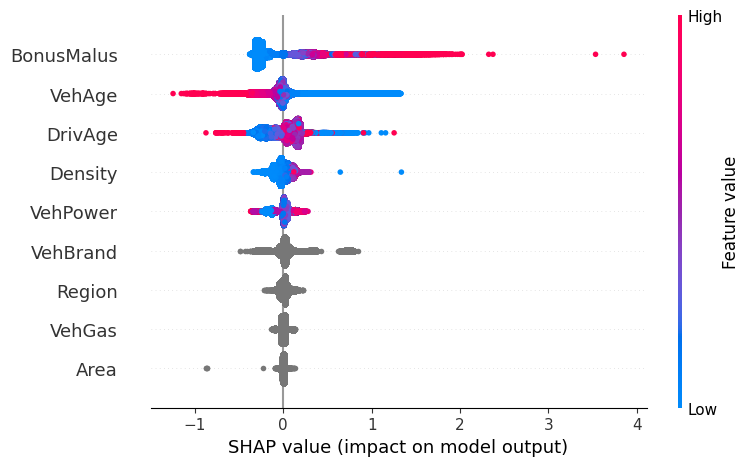

In [59]:
explainer = shap.TreeExplainer(FrequencyModel)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

In [60]:
catboost_predictions = FrequencyModel.predict(holdout_pool)

In [61]:
catboost_predictions

array([0.04642722, 0.01012589, 0.05036179, ..., 0.04649055, 0.15996015,
       0.03051501])

In [62]:
catboost_predictions = FrequencyModel.predict(holdout_pool)
holdout = (
    holdout.with_columns(FrequencyPrediction = pl.Series(catboost_predictions))
)

In [63]:
with open('./config/continous_factor_visuals.json', 'r') as f:
    continous_factor_config = json.load(f)

In [64]:
def band_continous(df, factor, lower_bound, upper_bound, step_size):

    banded_data = (
        df
        .with_columns(
            pl.col(factor).clip(lower_bound = lower_bound, upper_bound = upper_bound).alias(factor)
        )
        .with_columns(
            ((pl.col(factor)/step_size).floor()*step_size).alias(factor)
        )
    )    

    return banded_data


def aggregate_frequency_df(df, factor, continous_factor_config, claim_count = 'ClaimCount', exposure = 'Exposure', prediction = 'FrequencyPrediction'):

    if factor in continous_factor_config:
        lower_bound = continous_factor_config.get(factor).get('min')
        upper_bound = continous_factor_config.get(factor).get('max')
        step_size = continous_factor_config.get(factor).get('step')

        df = band_continous(df, factor, lower_bound, upper_bound, step_size)

    aggregated_df = (
        df
        .group_by(factor)
            .agg(
                pl.col(exposure).sum(), 
                pl.col(claim_count).sum(), 
                pl.col(prediction).sum()
            )
        .with_columns(Frequency = pl.col(claim_count) / pl.col(exposure))
        .with_columns(FrequencyPrediction = pl.col(prediction) / pl.col(exposure))
        .sort(factor)
    )

    return aggregated_df


def create_frequency_table(df, factor, frequency = 'Frequency', exposure = 'Exposure', prediction = 'FrequencyPrediction', experiment = 'Not Logged'):
    
    return (
        GT(df)
        .tab_header(
            title=f'Frequency - Actual vs Predicted - {factor}',
        )
        .tab_stub(rowname_col=factor)
        .tab_source_note(source_note=f'Trained on experiment: {experiment}')
        .tab_stubhead(label=factor)
        .fmt_integer(columns=exposure)
        .fmt_percent(columns=[frequency, prediction], decimals=1)
        .data_color(
            columns=[frequency, prediction],
            palette=["#63BE7B", "#FFEB84", "#F8696B"]
        )
        .cols_move(columns=prediction, after=frequency)
    )

def save_table_to_html(table, path):

    html_str = table.as_raw_html()
    with open(path, 'w', encoding='utf-8') as f:
        f.write(html_str)



def plot_aggregated_data(visual_data: pl.DataFrame, factor: str, target: str, prediction: str, exposure: str) -> None:

    fig = go.Figure()

    # Bar: Exposure
    fig.add_trace(go.Bar(
        x=visual_data[factor],
        y=visual_data[exposure],
        name=exposure,
        marker_color='lightskyblue',
        yaxis='y1'
    ))

    # Line: ClaimCount
    fig.add_trace(go.Scatter(
        x=visual_data[factor],
        y=visual_data[target],
        name=target,
        mode='lines+markers',
        line=dict(color='firebrick'),
        yaxis='y2'
    ))

    # Line: gbm_predictions
    fig.add_trace(go.Scatter(
        x=visual_data[factor],
        y=visual_data[prediction],
        name="Frequency Predictions",
        mode='lines+markers',
        line=dict(color='green', dash='dot'),
        yaxis='y2'
    ))

    # Layout with dual y-axes
    fig.update_layout(
        title=f"Frequency - Actuals vs Prediction - {factor}",
        xaxis=dict(title=factor),
        yaxis=dict(
            title=exposure,
            side="left",
            showgrid=False
        ),
        yaxis2=dict(
            title="Frequency",
            overlaying="y",
            side="right"
        ),
        barmode='group',
        legend=dict(x=0.01, y=0.99),
        height=900
    )

    fig.show()

In [65]:
factor = 'Area'

aggregated_data = aggregate_frequency_df(holdout, factor, continous_factor_config)
frequency_table = create_frequency_table(aggregated_data, factor = factor)
save_table_to_html(frequency_table, path=f'frequency-table-{factor}.html')
frequency_table

GT(_tbl_data=shape: (6, 5)
┌──────┬──────────────┬────────────┬─────────────────────┬───────────┐
│ Area ┆ Exposure     ┆ ClaimCount ┆ FrequencyPrediction ┆ Frequency │
│ ---  ┆ ---          ┆ ---        ┆ ---                 ┆ ---       │
│ str  ┆ f64          ┆ i32        ┆ f64                 ┆ f64       │
╞══════╪══════════════╪════════════╪═════════════════════╪═══════════╡
│ A    ┆ 12431.75503  ┆ 978        ┆ 0.079555            ┆ 0.07867   │
│ B    ┆ 8571.61018   ┆ 728        ┆ 0.086387            ┆ 0.084932  │
│ C    ┆ 21035.635869 ┆ 1931       ┆ 0.094381            ┆ 0.091797  │
│ D    ┆ 15435.785096 ┆ 1587       ┆ 0.107423            ┆ 0.102813  │
│ E    ┆ 12700.506092 ┆ 1601       ┆ 0.120026            ┆ 0.126058  │
│ F    ┆ 1621.628906  ┆ 251        ┆ 0.136308            ┆ 0.154783  │
└──────┴──────────────┴────────────┴─────────────────────┴───────────┘, _body=<great_tables._gt_data.Body object at 0x00000232AE462390>, _boxhead=Boxhead([ColInfo(var='Area', type=<ColInfoTypeEnum.stub: 2>, column_label='Area', column_align='left', column_width=None), ColInfo(var='Exposure', type=<ColInfoTypeEnum.default: 1>, column_label='Exposure', column_align='right', column_width=None), ColInfo(var='ClaimCount', type=<ColInfoTypeEnum.default: 1>, column_label='ClaimCount', column_align='right', column_width=None), ColInfo(var='Frequency', type=<ColInfoTypeEnum.default: 1>, column_label='Frequency', column_align='right', column_width=None), ColInfo(var='FrequencyPrediction', type=<ColInfoTypeEnum.default: 1>, column_label='FrequencyPrediction', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x00000232B942F3B0>, _spanners=Spanners([]), _heading=Heading(title='Frequency - Actual vs Predicted - Area', subtitle=None, preheader=None), _stubhead='Area', _source_notes=['Trained on experiment: Not Logged'], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='Frequency', rows=[0], mask=None), grpname=None, colname='Frequency', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#63be7b')]), StyleInfo(locname=LocBody(columns='Frequency', rows=[1], mask=None), grpname=None, colname='Frequency', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#7dc57c')]), StyleInfo(locname=LocBody(columns='Frequency', rows=[2], mask=None), grpname=None, colname='Frequency', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#99ce7e')]), StyleInfo(locname=LocBody(columns='Frequency', rows=[3], mask=None), grpname=None, colname='Frequency', rownum=3, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#c6db81')]), StyleInfo(locname=LocBody(columns='Frequency', rows=[4], mask=None), grpname=None, colname='Frequency', rownum=4, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#fdcb7e')]), StyleInfo(locname=LocBody(columns='Frequency', rows=[5], mask=None), grpname=None, colname='Frequency', rownum=5, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f8696b')]), StyleInfo(locname=LocBody(columns='FrequencyPrediction', rows=[0], mask=None), grpname=None,

In [66]:
plot_aggregated_data(visual_data = aggregated_data, 
                        factor = factor, 
                        target = 'Frequency', 
                        prediction = 'FrequencyPrediction',
                        exposure = 'Exposure')

In [67]:
factor = 'DrivAge'

aggregated_data = aggregate_frequency_df(holdout, factor, continous_factor_config)
frequency_table = create_frequency_table(aggregated_data, factor = factor)
save_table_to_html(frequency_table, path=f'frequency-table-{factor}.html')
frequency_table

GT(_tbl_data=shape: (13, 5)
┌─────────┬─────────────┬────────────┬─────────────────────┬───────────┐
│ DrivAge ┆ Exposure    ┆ ClaimCount ┆ FrequencyPrediction ┆ Frequency │
│ ---     ┆ ---         ┆ ---        ┆ ---                 ┆ ---       │
│ f64     ┆ f64         ┆ i32        ┆ f64                 ┆ f64       │
╞═════════╪═════════════╪════════════╪═════════════════════╪═══════════╡
│ 20.0    ┆ 2513.914099 ┆ 460        ┆ 0.189421            ┆ 0.182982  │
│ 25.0    ┆ 5110.920644 ┆ 538        ┆ 0.111561            ┆ 0.105265  │
│ 30.0    ┆ 7871.5223   ┆ 673        ┆ 0.090433            ┆ 0.085498  │
│ 35.0    ┆ 8770.742387 ┆ 789        ┆ 0.088169            ┆ 0.089958  │
│ 40.0    ┆ 8794.002106 ┆ 838        ┆ 0.096094            ┆ 0.095292  │
│ …       ┆ …           ┆ …          ┆ …                   ┆ …         │
│ 60.0    ┆ 4396.858498 ┆ 426        ┆ 0.090503            ┆ 0.096887  │
│ 65.0    ┆ 3578.601975 ┆ 322        ┆ 0.09335             ┆ 0.089979  │
│ 70.0    ┆ 2915.518685 ┆ 251        ┆ 0.096469            ┆ 0.086091  │
│ 75.0    ┆ 1921.934757 ┆ 204        ┆ 0.098482            ┆ 0.106143  │
│ 80.0    ┆ 1204.602025 ┆ 114        ┆ 0.098446            ┆ 0.094637  │
└─────────┴─────────────┴────────────┴─────────────────────┴───────────┘, _body=<great_tables._gt_data.Body object at 0x000002324B4A97C0>, _boxhead=Boxhead([ColInfo(var='DrivAge', type=<ColInfoTypeEnum.stub: 2>, column_label='DrivAge', column_align='right', column_width=None), ColInfo(var='Exposure', type=<ColInfoTypeEnum.default: 1>, column_label='Exposure', column_align='right', column_width=None), ColInfo(var='ClaimCount', type=<ColInfoTypeEnum.default: 1>, column_label='ClaimCount', column_align='right', column_width=None), ColInfo(var='Frequency', type=<ColInfoTypeEnum.default: 1>, column_label='Frequency', column_align='right', column_width=None), ColInfo(var='FrequencyPrediction', type=<ColInfoTypeEnum.default: 1>, column_label='FrequencyPrediction', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x00000232AE463CB0>, _spanners=Spanners([]), _heading=Heading(title='Frequency - Actual vs Predicted - DrivAge', subtitle=None, preheader=None), _stubhead='DrivAge', _source_notes=['Trained on experiment: Not Logged'], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='Frequency', rows=[0], mask=None), grpname=None, colname='Frequency', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f8696b')]), StyleInfo(locname=LocBody(columns='Frequency', rows=[1], mask=None), grpname=None, colname='Frequency', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#a4d17f')]), StyleInfo(locname=LocBody(columns='Frequency', rows=[2], mask=None), grpname=None, colname='Frequency', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#66bf7b')]), StyleInfo(locname=LocBody(columns='Frequency', rows=[3], mask=None), grpname=None, colname='Frequency', rownum=3, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#74c37c')]), StyleInfo(locname=LocBody(columns='Frequency', rows=[4], mask=None), grpname=None, colname='Frequency', rownum=4, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#85c87d')]), StyleInfo(locname=LocBody

In [69]:
plot_aggregated_data(visual_data = aggregated_data, 
                        factor = factor, 
                        target = 'Frequency', 
                        prediction = 'FrequencyPrediction',
                        exposure = 'Exposure')